# Machine Learning HW4

### Author: Ze Yang (zey@andrew.cmu.edu)

In [184]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import rpy2
%reload_ext rpy2.ipython
import time
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, \
    roc_curve, confusion_matrix, auc
from sklearn.decomposition.kernel_pca import KernelPCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from copy import copy
from progressbar import ProgressBar
from tabulate import tabulate


def plot_digit(x):
    plt.imshow(x.reshape((16,16)), cmap=plt.cm.gray)


# PCA
## (a) Fit the PCA

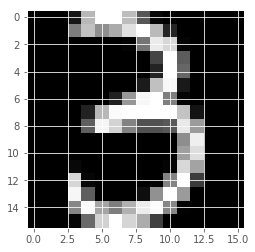

In [37]:
# load data
df_threes = pd.read_csv('threes.csv')
X = df_threes.values
plot_digit(X[1,:])

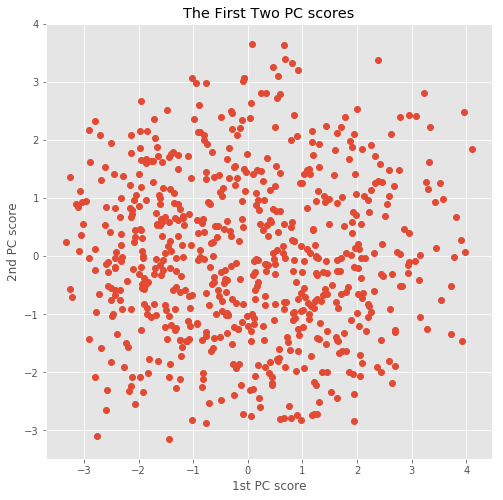

In [30]:
# First 2 PC scores
pca = PCA()
pca.fit(X); pc = pca.components_
pc_scores = pca.transform(X)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(pc_scores[:,0], pc_scores[:,1], 'o')
_ = ax.update({
    'title': 'The First Two PC scores',
    'xlabel': '1st PC score', 
    'ylabel': '2nd PC score'})

## (b) Representative Grid of Points

[[163 547  20 286 488]
 [280  83 132   3 488]
 [480 487 553 416 204]
 [150 343 141 404 172]
 [183  68 326 224 654]]


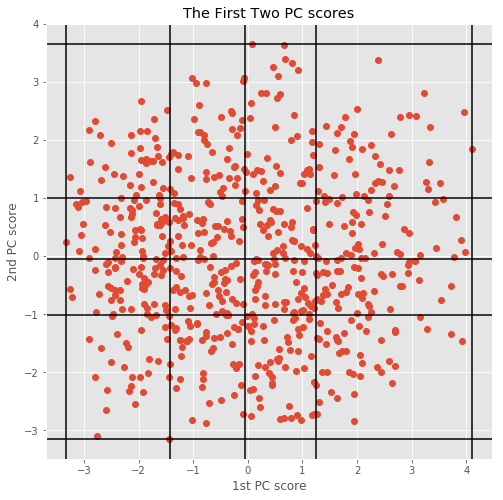

In [130]:
import itertools
def quantile_grid(x,y,q):
    q = np.array(q)
    xq = np.percentile(x,100*q)
    yq = np.percentile(y,100*q)
    idx_list = np.zeros(len(q)**2, dtype=np.int_)
    i = 0
    for ypt, xpt in itertools.product(yq,xq):
        idx_list[i] = np.argmin((x-xpt)**2+(y-ypt)**2)
        i += 1
    return xq, yq, idx_list.reshape((len(q),len(q)))

xq, yq, representatives = quantile_grid(
    pc_scores[:,0], pc_scores[:,1], [0,.25,.5,.75,1])

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(pc_scores[:,0], pc_scores[:,1], 'o')
for x in xq: ax.axvline(x, color='black')
for y in yq: ax.axhline(y, color='black')
_ = ax.update({
    'title': 'The First Two PC scores',
    'xlabel': '1st PC score', 
    'ylabel': '2nd PC score'})

print(representatives)

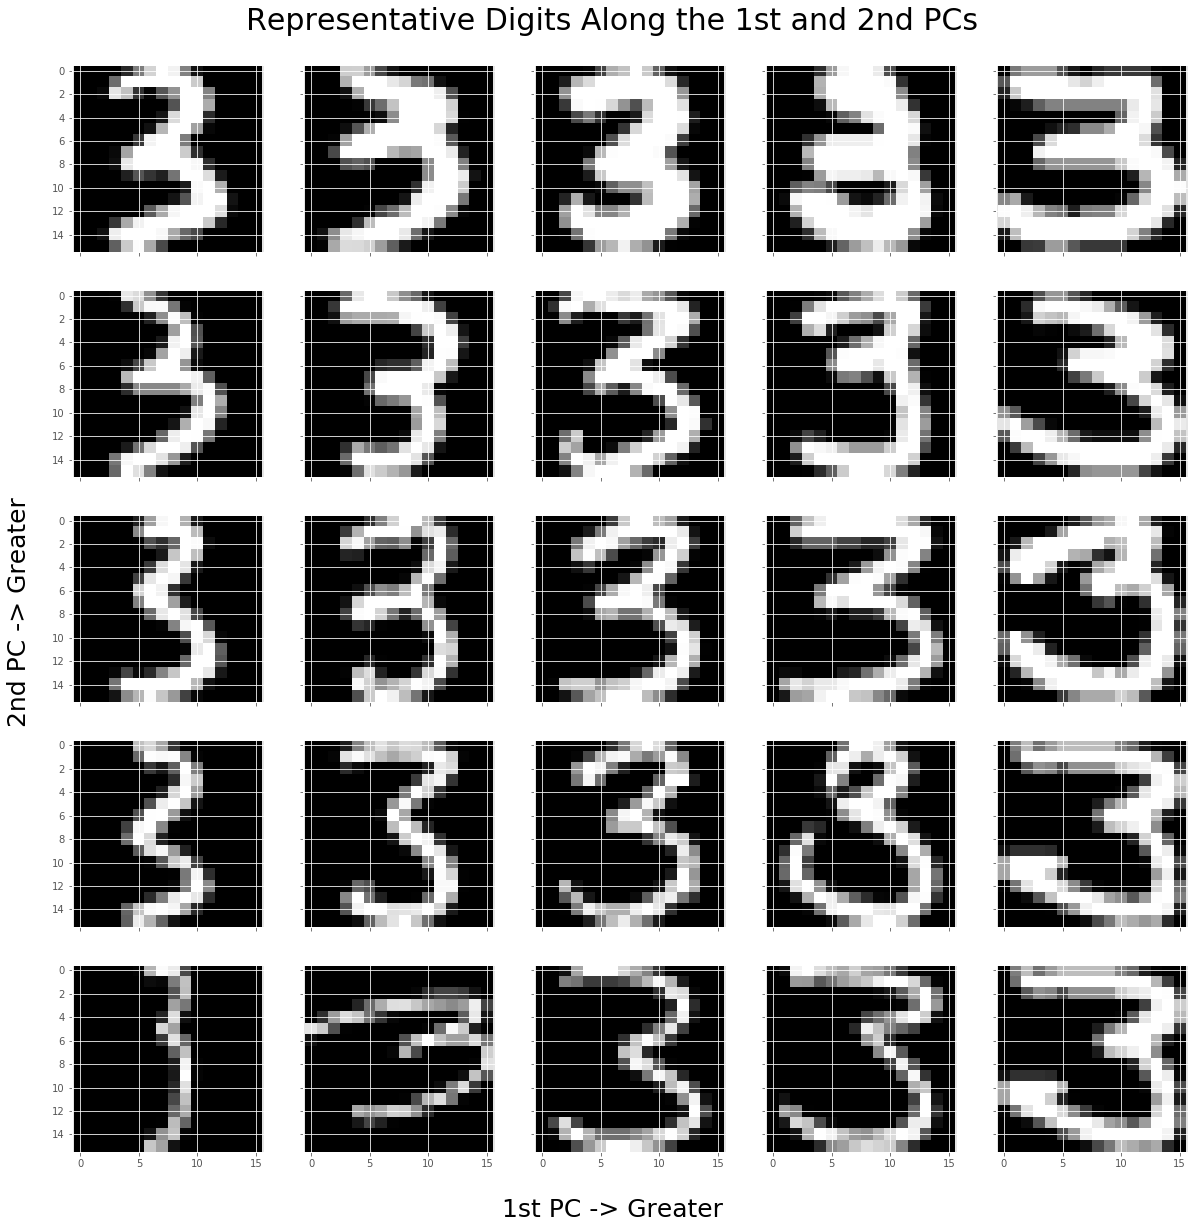

In [129]:
fig, axes = plt.subplots(
    5,5,figsize=(20,20),sharex=True, sharey=True)
for i in range(5):
    for j in range(5):
        idx = representatives[i,j]
        # i: 2nd pc decrease
        # j: 1st pc increase
        axes[4-i][j].imshow(
            X[idx,:].reshape((16,16)), 
            cmap=plt.cm.gray)
fig.text(
    0.5, 0.08, '1st PC -> Greater', 
    ha='center', fontsize=25)
fig.text(
    0.08, 0.5, '2nd PC -> Greater', va='center', 
    rotation='vertical', fontsize=25)
_ = fig.suptitle(
    'Representative Digits Along the 1st and 2nd PCs',
    y=0.92,fontsize=30)

## (c) Meaning of the First 2 PCs

The 5 by 5 panel indicates the meaning of the first 2 PCs:
- The First PC: We can observe the representative digits get wider and fatter as it going from left to right (increase in PC1 direction). We can deduce that, the **"wideness and fatness"** of the digits increases with respect to the increase the PC1 scores.
- The Second PC: We can observe the **stroke** of representative digits get thicker as it going from bottom to up (increase in PC2 direction). So we can say that, the **"thickness of the strokes"** of the digits increases with respect to the increase the PC2 scores.

## (d) Proportion of Variance Explained

Variance explained up to PC 6: 46.616%
Variance explained up to PC 7: 50.648%
Variance explained up to PC 51: 89.995%
Variance explained up to PC 52: 90.247%


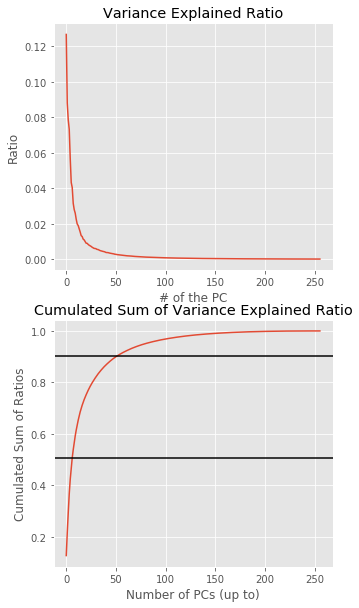

In [136]:
fig, axes = plt.subplots(2,1,figsize=(5,10))
axes[0].plot(pca.explained_variance_ratio_)
total_var_ratio = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(total_var_ratio)
stop = np.argmax(total_var_ratio > 0.5)
stop_2 = np.argmax(total_var_ratio > 0.9)
axes[1].axhline(y=total_var_ratio[stop],color='black')
axes[1].axhline(y=total_var_ratio[stop_2],color='black')
print("Variance explained up to PC %d: %.3f%%" % (
    stop, total_var_ratio[stop-1]*100))
print("Variance explained up to PC %d: %.3f%%" % (
    stop+1, total_var_ratio[stop]*100))
print("Variance explained up to PC %d: %.3f%%" % (
    stop_2, total_var_ratio[stop_2-1]*100))
print("Variance explained up to PC %d: %.3f%%" % (
    stop_2+1, total_var_ratio[stop_2]*100))
_ = axes[0].update({
    'title': 'Variance Explained Ratio',
    'xlabel': '# of the PC', 
    'ylabel': 'Ratio'})
_ = axes[1].update({
    'title': 'Cumulated Sum of Variance Explained Ratio',
    'xlabel': 'Number of PCs (up to)', 
    'ylabel': 'Cumulated Sum of Ratios'})

- 7 Principle components will be needed to explain 50% of the variance; 52 PCs needed to explain 90% of the variance.

## (e) First 4 PC Directions

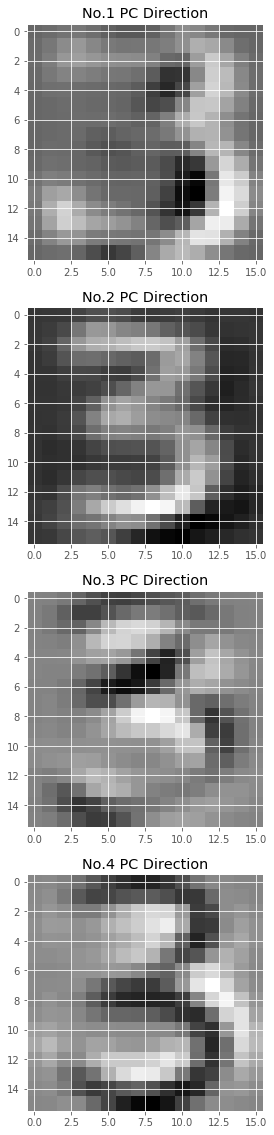

In [139]:
fig, axes = plt.subplots(4,1,figsize=(10,20))
for j in range(4):
    axes[j].imshow(
        pc[j,:].reshape((16,16)), 
        cmap=plt.cm.gray)
    axes[j].update({
        'title': 'No.%d PC Direction' % (j+1)
    })

- The first figure corresponds to the unit change from a mean three along the 1st PC's direction. As we discussed in (b),(c), the **"wideness and fatness"** of the digits increases with respect to the increase the PC1 scores. This matches this 1st PC direction's plot, as it exactly appears to be a wide 3. (colormap: white pixels has large value, dark pixels has small value)
- The 2nd figure corresponds to the unit change from a mean three along the 1st PC's direction. As we discussed in (b),(c), **"thickness of the strokes"** of the digits increases with respect to the increase the PC2 scores. This also matches this 2nd PC direction's plot, which has large positive values at the main-body stroke of a mean 3, and small or negative values elsewhere. If a digit has large scores in this direction, the main-body stroke is strengthened with litte impact elsewhere.

# Unfolding a Spiral

## (a) Spiral Data

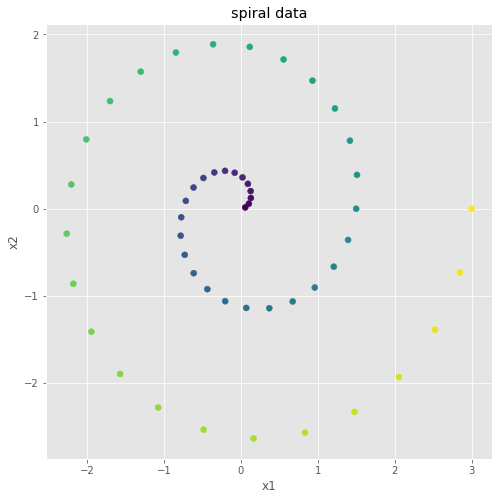

In [145]:
spiral = pd.read_csv('spiral.csv')
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(spiral['x1'], spiral['x2'], c=spiral['y'])
_ = ax.update({
    'title': 'spiral data',
    'xlabel':'x1', 'ylabel':'x2'})

- The pattern is: the $y$ value increases as the scatter goes from the center ("eye") of the spiral to its periphery ("arm").
- Linear regression is likely to perform poorly on this data, because the relationship between $(x_1, x_2)$ and $y$ is clearly not linear.

## (b) Try Linear Regression

Train MSE: 19.443549798541447


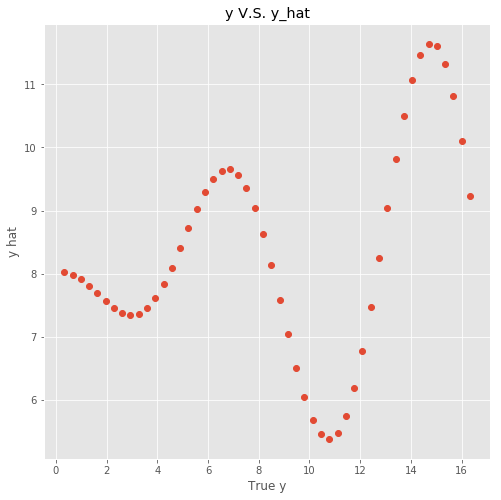

In [156]:
clf = LinearRegression()
clf.fit(spiral[['x1','x2']], spiral['y'])
y_hat = clf.predict(spiral[['x1','x2']])
print('Train MSE:', mean_squared_error(spiral['y'], y_hat))
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(spiral['y'], y_hat, 'o')
_ = ax.update({
    'title': 'y V.S. y_hat',
    'xlabel':'True y', 'ylabel':'y hat'})

- The mse is 19.443549798541447.
- The $y$ V.S. $\hat{y}$ plot is far from the 45 degree line, and it has some non-linear pattern.
- We are doing poorly with linear regression.

## (c) Naive Euclidean Distance

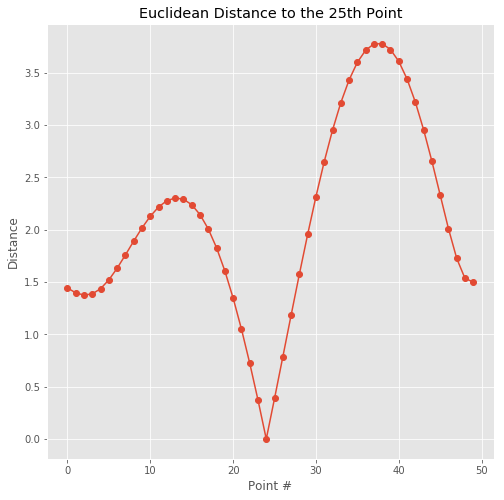

In [164]:
dist_eu = euclidean_distances(spiral[['x1','x2']])
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(dist_eu[24,:], 'o-')
_ = ax.update({
    'title': 'Euclidean Distance to the 25th Point',
    'xlabel':'Point #', 'ylabel':'Distance'})

## (d) Distance in Isomap Space

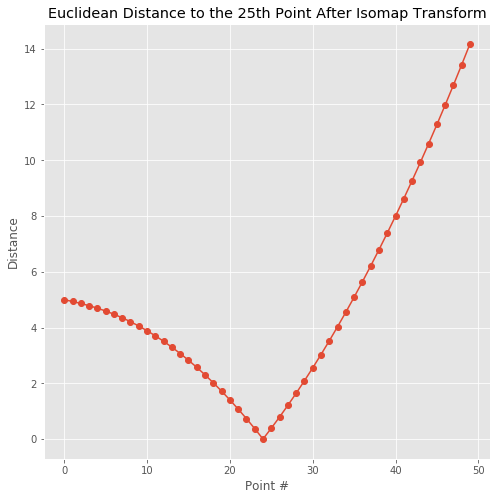

In [168]:
imap = Isomap(n_neighbors=1,n_components=2)
Z = imap.fit_transform(spiral[['x1','x2']])
dist_imap = imap.dist_matrix_
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(dist_imap[24,:], 'o-')
_ = ax.update({
    'title': 'Euclidean Distance to the 25th Point After Isomap Transform',
    'xlabel':'Point #', 'ylabel':'Distance'})

- Yes, after Isomap transform, the distance now increases monotonically away from the 25th point.


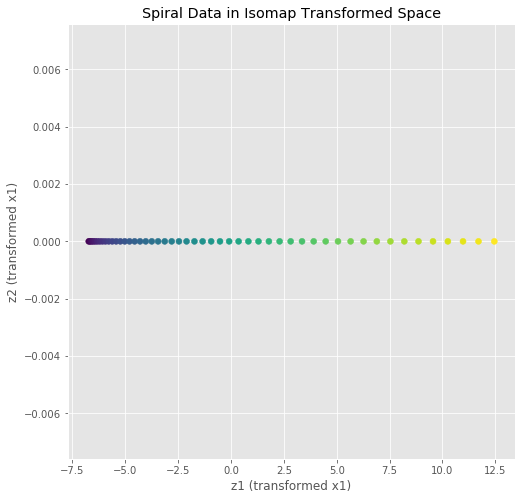

In [171]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(Z[:,0], Z[:,1], c=spiral['y'])
_ = ax.update({
    'title': 'Spiral Data in Isomap Transformed Space',
    'xlabel':'z1 (transformed x1)', 'ylabel':'z2 (transformed x1)'})

- The spiral was unfolded after the Isomap transform, and the correlation between $(z_1, z_2)$ and $y$ now becomes linear.

## (e) Linear Regression on Tranformed Coordinates

Train MSE: 0.6830205750315524


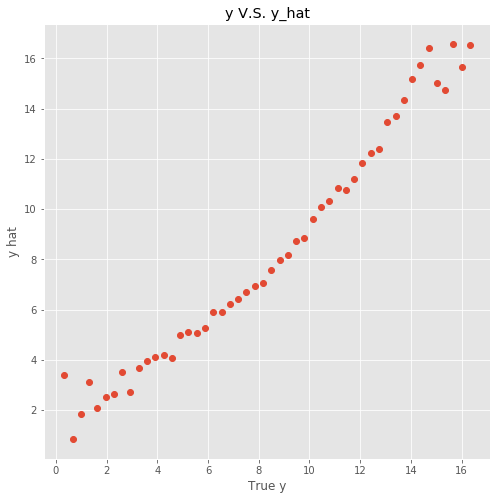

In [172]:
clf2 = LinearRegression()
clf2.fit(Z, spiral['y'])
y_hat = clf2.predict(Z)
print('Train MSE:', mean_squared_error(spiral['y'], y_hat))
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(spiral['y'], y_hat, 'o')
_ = ax.update({
    'title': 'y V.S. y_hat',
    'xlabel':'True y', 'ylabel':'y hat'})

- The training mse is now only 0.6830, sharply decreased from the our first attempt.
- The y V.S. ŷ plot is now close enough to the 45 degree line.
- We are doing well with linear regression on transformed coordinates.

# MDS

In [197]:
df_dist = pd.read_csv('nyc_dist.csv')
loc_names =list(df_dist.columns)[1:]
D = df_dist.iloc[:,1:].values
n = D.shape[0]
IminusM = np.eye(n) - np.ones((n, n))/n
B = -IminusM.dot(D**2).dot(IminusM)/2
mds = KernelPCA(
    kernel='precomputed', n_components=2)
D_mds = mds.fit_transform(B)

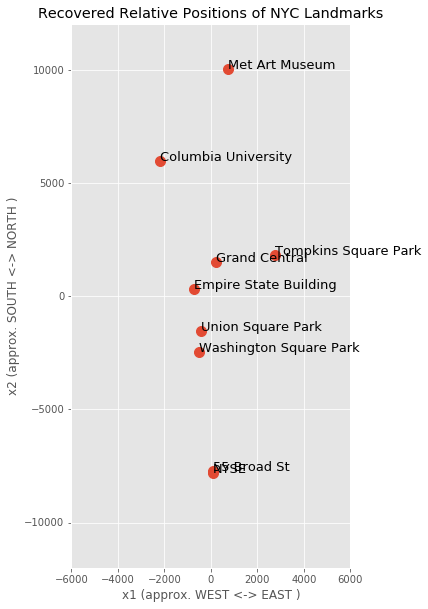

In [224]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
ax.plot(D_mds[:,1], -D_mds[:,0], 'o', markersize=10)
for i, loc in enumerate(loc_names):
    ax.text(D_mds[i,1], -D_mds[i,0], loc, size=13)
_ = ax.update({
    'title': 'Recovered Relative Positions of NYC Landmarks',
    'xlabel':'x1 (approx. WEST <-> EAST )', 
    'ylabel':'x2 (approx. SOUTH <-> NORTH )',
    'xlim':(-6000,6000), 'ylim':(-12000,12000)})

- The relative positions of NYC landmarks are recovered quite well.
- One exception: the Columbia University is at wrong relative position. It should be to the north of Met Art Museum, but now it's on the south of it. Though the west-east relative position of Columbia U seems to be correct.
